
# <center> Approximate Quantum Compiling for Quantum Simulation </center>

<center>Niall F. Robertson, Albert Akhriev and Sergiy Zhuk <br> IBM Research Ireland, 2023 </center>

## The Problem Formulation

The simulation of quantum spin chains is a promising candidate for the demonstration of quantum advantage. One of the main obstacles to achieving this is the noise that arises from implementing the deep circuits that appear in standard quantum time evolution algorithms. Compiling these deep circuits into shallower ones is thus a key issue that we address in this presentation. We use a Tensor Network based approach to Approximate Quantum Compiling to produce short depth quantum circuits that simulate the time evolution of the Heisenberg spin chain on up to 100 qubits. Please, refer to the papers [1, 2] for the technical details.

We will consider the $XXX$ spin-chain $-$ a paradigmatic model for quantum magnetism $-$ defined by the Hamiltonian:
$$
H_{XXX} = -\sum\limits_{i=0}^{L−1} h_{i,i+1} = 
−\sum\limits_{i=0}^{L−1} S^x_i S^x_{i+1} + S^y_i S^y_{i+1} + \delta S^z_i S^z_{i+1}, \qquad\qquad (1)
$$
where $S^x$, $S^y$ and $S^z$ are written in terms of Pauli matrices as $S^x$ = $\sigma^x/2$, $S^y$ = $\sigma^y_2$ and $S^z$ = $\sigma^z/2$, and $\delta$ is a tunable parameter (here, $\delta = 1$ always). This Hamiltonian is a prototypical example of an integrable $1D$ model.

The time evolution of a quantum state $|{\psi(t)}\rangle$ is governed by the Schr&ouml;dinger equation:
$$
|{\psi(t)}\rangle = e^{-iH_{XXX}t} |{\psi_0}\rangle, \qquad\qquad (2)
$$
where $|{\psi_0}\rangle$ is the wavefunction at time $t=0$. In this work, we will consider the N&eacute;el state, written as: $|{\uparrow\downarrow\uparrow\downarrow...\uparrow\downarrow}\rangle$ where $\uparrow$ and $\downarrow$ represent up and down spins respectively. The N&eacute;el state for $n$ spins is simply implemented on $n$ qubits as $|{1010...10}\rangle$.

Our goal is to reduce the depth of Trotterized time-evolution operator in (2) by replacing it with a relatively shallow but more flexible parametrized ansatz. This is achieved by calculating so-called *ground-truth* target states for several time horizons, obtained by applying Trotterized circuits to some initial state. Then, a shorter parameterized ansatz is optimized to get as close as possible to the ground-truth states defined at few points on the time axis. Subsequently, one can use optimized ansatz instead of exact Trotter circuit on the real quantum hardware. 

In all the experiments we have been using N&eacute;el initial state $|{\psi_0}\rangle = |101010{\ldots}\rangle$ (generated by the function ``neel_init_state()`` in the code), which is *not* an eigenstate of Trotter operator $T$. One can also define a custom generator of a *weakly-entangled* initial state (parameter ``ini_state_func`` in user options). The ground-truth target states, computed for several time horizons, serve as the objectives for training parametrized ansatz $V(\Theta)$, which is always applied to zero state $|0\rangle$. Conceptually, we want to minimize the difference $\|V(\Theta) |0\rangle - T |{\psi_0}\rangle\|^2$, although the actual objective function is a bit more involved as detailed in [2].   

The ground-truth target states are computed *classically* either employing full state vectors with $2^n$ entries or their compact Matrix Product State (``MPS``) representation as provided by Qiskit. The latter suits for simulations with large number qubits, $n > 24$, while optimization with full state vectors can be faster for moderate number qubits, $n \le 24$. In any case, generating the target states classically can be very computationally demanding procedure. There is an option (parameter ``target_only`` in user settings) that allows to pre-compute targets before doing any optimization. Once this is done, one can tweak the optimization process reusing existing targets. Please, note that targets are always computed for the *particular* Hamiltonian and initial state. Along with the ground-truth states, calculated with high precision, we also compute less accurate *reference* state in order to compare their performance against optimized approximating ansatz.

## Starting remarks

Few common remarks at the beginning. It is recommended to install ``Latex`` to make plots' presentation more attractive. In the experiments that follow, a long output listing with a picture at the end can be automatically reduced into scrollable window by the Jupyter notebook. In that situation, pressing the menu item "Cell/All Output/Toggle Scrolling" can solve the visibility problem.

The code presented in this notebook relies on functionality of the script ``run_time_evol_best_init.py``, which can be found in the main package. We recommend to use that script directly because the run time can be very long (days and weeks for the large number of qubits). 

Once the simulation has finished, several files will be saved in the result directory:
* ``all_results.pkl`` - archive contains simulation results per time horizon.
* ``fidelity_plot_nXX_br3.png`` - picture shows fidelities of $|a_1\rangle$ and $|t_1\rangle$ against the ground-truth one $|t_{gt}\rangle$, see below.
* ``time_evol_best_init.py`` - the script that implements the computational model.
* ``user_options.pkl`` - instance of ``UserOptions`` class used in simulation. 

User may choose to run a simulation from terminal rather than Jupyter notebook using the launching script ``run_time_evol.py``, possibly with parameters customization. That script will also be saved in the result directory. In any case, whether a terminal or a notebook is being used, the output result directory will contain enough information to reproduce the numerical experiment it was created by. 

Let us start from defining the user options, which will be printed out once a simulation commenced.

#### Module paths

If running this notebook without installation, directly *from the root folder* of the package downloaded from the GitHub, the following ``bash`` snippet helps to resolve module paths:

```
(export PYTHONPATH=`pwd` && echo "Python path: ${PYTHONPATH}" && jupyter notebook docs/time_evolution.ipynb)
```

In [1]:
import sys, time, logging, os, glob
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Union
from pprint import pprint
import pickle
from qiskit import QuantumCircuit
from aqc_research.parametric_circuit import TrotterAnsatz
from aqc_research.circuit_structures import make_trotter_like_circuit
from aqc_research.circuit_transform import ansatz_to_qcircuit
from aqc_research.mps_operations import no_truncation_threshold
import aqc_research.model_sp_lhs.trotter.trotter as trotop
import aqc_research.model_sp_lhs.trotter.trotter_evol_utils as trotul
from aqc_research.model_sp_lhs.time_evol_best_init import run_simulation
from aqc_research.model_sp_lhs.user_options import UserOptions

# Create an instance of user options.
opts = UserOptions()
opts.tag = "notebook"

## Initialization

The important point of our framework is what we called the *perfect* or the *best* initial guess $\Theta_0$ of angular parameters used as a starting vector by the ansatz optimization procedure. The idea is demonstrated by the function ``plot_trotter_blocks()`` below. The elementary Trotter block, depicted on the top, is explained in [2], Figure.2. The block in the middle picture, which we use in ansatz, has more parameters, hence, more flexible albeit with the same number of $CX$-gates. The perfect initialization can be obtained by setting all but three angular parameters in the generic block to zero. Non-zero angles take their values from the Trotter block with one exception: the top-middle $R_z$ gate is swapped with the middle $CX$-gate, which is admissible in the particular configuration where only $3$ out $12$ parameters have non-zero values. One can check that the top and the bottom blocks produce the same matrix operator.

With perfect initialization we start the optimization procedure from exactly the Trotter circuit. As the result, ``L-BFGS`` optimizer typically converges to satisfactory loss value in less than $40$ iterations. Alternatively, one can use a random initial guess for $\Theta_0$. In this case, multiple parallel simulations would be needed in order to guarantee acceptable loss value, and even with multiple restarts optimization often stacks in local minimum or struggling to converge over hundreds of iterations.

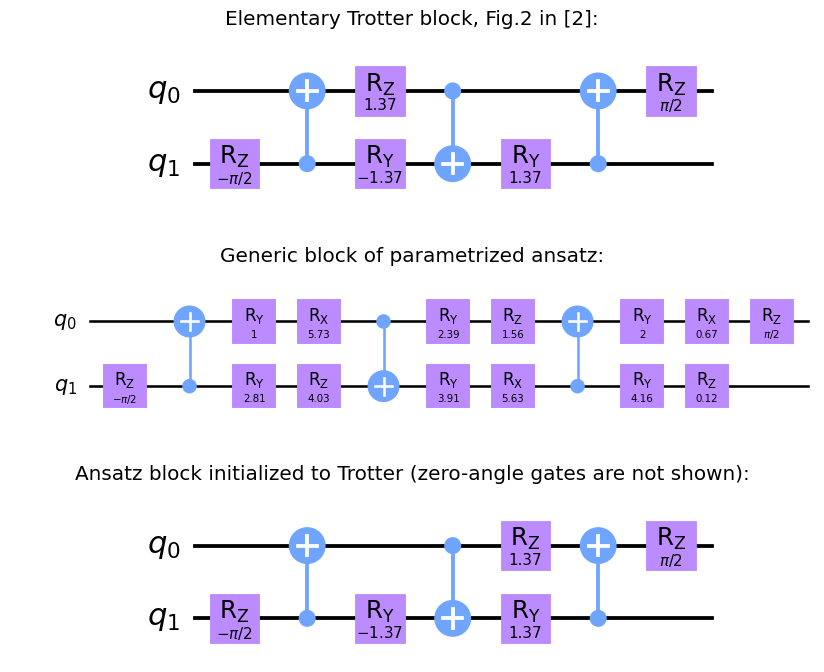

In [2]:
def plot_trotter_blocks():
    # Plots the block structure.
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(9,7))
    fig.tight_layout()
    axs[0].title.set_text("Elementary Trotter block, Fig.2 in [2]:")
    qc = trotop.trotter_circuit(qc=QuantumCircuit(2), dt=0.4, delta=1.0, num_trotter_steps=1, second_order=False)
    qc.draw(output="mpl", ax=axs[0])
    axs[1].title.set_text("Generic block of parametrized ansatz:")
    blocks = make_trotter_like_circuit(num_qubits=2, num_layers=1)
    circ = TrotterAnsatz(num_qubits=2, blocks=blocks, second_order=False)
    thetas = np.round(2 * np.pi * (0.01 + 0.98 * np.random.rand(circ.num_thetas)), 2)
    thetas[0 : 6] = 0  # drops front layer
    qc = ansatz_to_qcircuit(circ=circ, thetas=thetas, tol=1e-8)
    qc.draw(output="mpl", ax=axs[1])
    axs[2].title.set_text("Ansatz block initialized to Trotter (zero-angle gates are not shown):")
    blocks = make_trotter_like_circuit(num_qubits=2, num_layers=1)
    circ = TrotterAnsatz(num_qubits=2, blocks=blocks, second_order=False)
    thetas = trotop.init_ansatz_to_trotter(circ=circ, thetas=thetas, evol_time=0.4, delta=1.0, layer_range=None)
    qc = ansatz_to_qcircuit(circ=circ, thetas=thetas, tol=1e-8)
    qc.draw(output="mpl", ax=axs[2])
    
def plot_fidelities(result_dir: str):
    # Loads and displays the fidelity chart of selected result.
    files = glob.glob(os.path.join(result_dir, "fidelity_plot_n*.png"))
    assert len(files) > 0, "unable to find fidelity chart"
    plt.rcParams["figure.figsize"] = [14.0, 10.0]
    #plt.rcParams["figure.autolayout"] = True
    im = plt.imread(files[0])
    fig, ax = plt.subplots()
    im = ax.imshow(im)
    plt.axis("off")
    plt.show()
    
plot_trotter_blocks()

## Experiment 1: MPS state vectors and perfect initialization

The code below takes N&eacute;el initial state $|{\psi_0}\rangle$ and the perfect initial guess to find approximating ansatz which is $1.5$ times shorter than the Trotter circuit that produces the reference target state. In this experiment we use MPS representation of state vectors. 

Abbreviations:
* $|a_1\rangle = V(\Theta) |0\rangle$, state obtained by applying ansatz operator $V(\Theta)$ to zero state $|0\rangle$.
* $|t_1\rangle = T |{\psi_0}\rangle$, reference state produced by Trotter circuit of moderate accuracy applied to initial state.
* $|t_{gt}\rangle = T_{precise} |{\psi_0}\rangle$, ground-truth state produced by precise (deep) Trotter circuit applied to initial state. 

Chart that appears by the end of the simulation shows fidelities of $|a_1\rangle$ and $|t_1\rangle$ against the ground-truth one $|t_{gt}\rangle$.

The subscript "1" implies two-stage quantum simulation. First, we find an ansatz circuit, which is shorter than Trotter one. The simulation starts from initial unentangled state $|0\rangle$ and produces $|a_1\rangle \approx |t_1\rangle$, which has *low* entanglement, otherwise MPS would be inpractical. Second, the state $|a_1\rangle$ serves as initial state to the next stage, where we propagate it further in time: $|t_2\rangle = T |a_1\rangle$ by an exact Trotter circuit. The overall depth should be considerably smaller comparing to double Trotter circuit. 

2023-05-04 20:18:57 | time_evol_best_init.py | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'delta': 1.0,
 'enable_grad_scaling': True,
 'evol_times': array([1.2, 2.4, 3.6, 4.8, 6. , 7.2]),
 'fidelity_thr': 0.995,
 'ini_state_func': (<function neel_init_state at 0x12c200940>,),
 'manual_num_layers': None,
 'maxiter': 40,
 'num_layers_inc': 2,
 'num_qubits': 9,
 'objective': 'sur_fast_mps_trotter',
 'result_dir': '/private/tmp/aqc-research/docs/results/trotter_evol',
 'save_intermediate_results': False,
 'second_order_trotter': True,
 'seed': 1683227900,
 'tag': 'notebook',
 'target_only': False,
 'targets_file': '',
 'time_limit': -1,
 'trotter_steps': array([ 3,  6,  9, 12, 15, 18]),
 'trunc_thr': 1e-06,
 'trunc_thr_target': 1e-16,
 'verbose': True}
--------------------------------------------------------------------------------

2023-05-04 20:18:57 | 

2023-05-04 20:19:18 | time_evol_best_init.py | info | Final objective function value: 0.000834
2023-05-04 20:19:18 | time_evol_best_init.py | info | done |a1> state in 9.651 secs
2023-05-04 20:19:18 | trotter_evol_utils.py | info | 
------------------------
Sorted valid results:
       cost  fidelity  num_iters      time
0  0.000834  0.999166          4  9.650853

2023-05-04 20:19:18 | time_evol_best_init.py | info | the final result will be recomputed without truncation ...
2023-05-04 20:19:19 | time_evol_best_init.py | info | 
{'fid_a1_vs_gt': '0.999151',
 'fid_a1_vs_t1': '0.999198',
 'fid_t1_vs_gt': '0.998964'}
--------------------------------------------------------------------------------
2023-05-04 20:19:19 | time_evol_best_init.py | info | 
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Evolution time: 4.800000
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
2023-05-04 20:19:19 | time_evol_best_init.py | info | Fidelity threshold: 0.9985
2023-05-04 20:

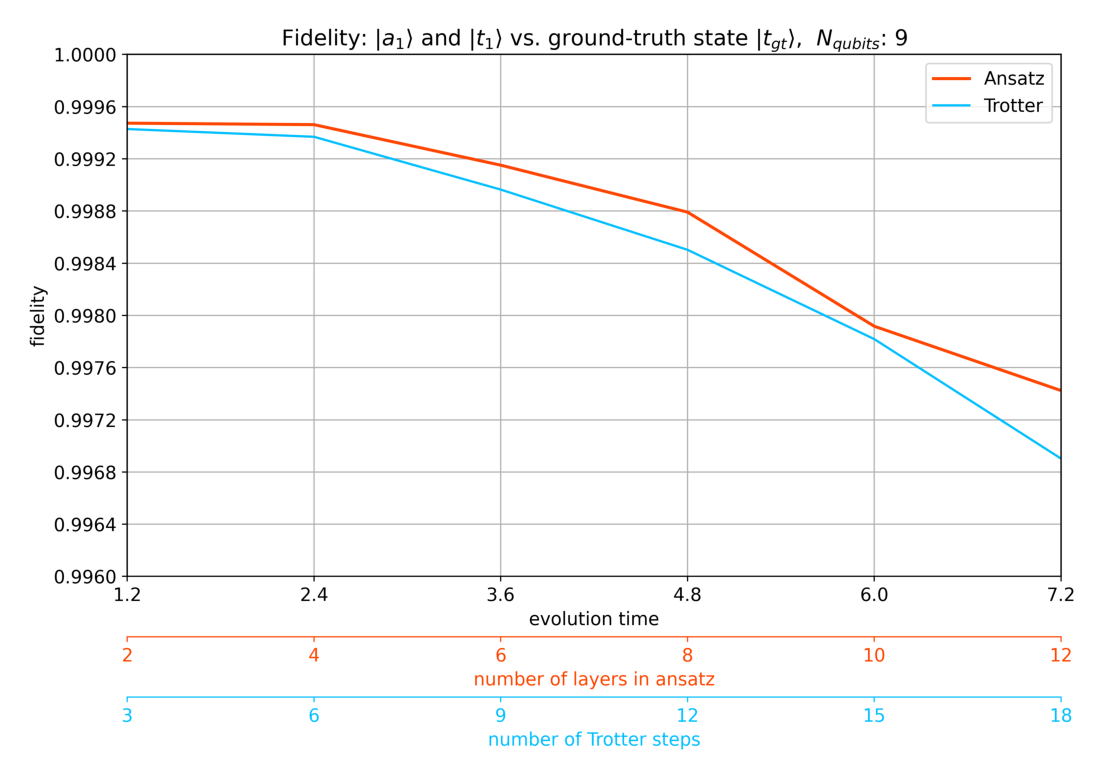

In [3]:
# Tweak the user options.
opts.num_qubits = 9
opts.objective = "sur_fast_mps_trotter"

# Find the approximating ansatz.
tic = time.time()
out_dir = run_simulation(opts)
print(f"Simulation time: {time.time() - tic:0.1f} secs")
print("Output directory of results:", out_dir)
plot_fidelities(out_dir)

## Experiment 2: full state vectors and perfect initialization

This is essentially the same experiment, but we shall be using full state vectors with $2^n$ entries instead of MPS ones. For a moderate number of qubits (here, $n = 9$), simulation based on full vectors is significantly faster.

2023-05-04 20:20:29 | time_evol_best_init.py | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'delta': 1.0,
 'enable_grad_scaling': True,
 'evol_times': array([1.2, 2.4, 3.6, 4.8, 6. , 7.2]),
 'fidelity_thr': 0.995,
 'ini_state_func': (<function neel_init_state at 0x12c200940>,),
 'manual_num_layers': None,
 'maxiter': 40,
 'num_layers_inc': 2,
 'num_qubits': 9,
 'objective': 'sur_max',
 'result_dir': '/private/tmp/aqc-research/docs/results/trotter_evol',
 'save_intermediate_results': False,
 'second_order_trotter': True,
 'seed': 1683227900,
 'tag': 'notebook',
 'target_only': False,
 'targets_file': '',
 'time_limit': -1,
 'trotter_steps': array([ 3,  6,  9, 12, 15, 18]),
 'trunc_thr': 1e-06,
 'trunc_thr_target': 1e-16,
 'verbose': True}
--------------------------------------------------------------------------------

2023-05-04 20:20:29 | target_states

2023-05-04 20:20:34 | time_evol_best_init.py | info | #layers: 6, evol.time: 3.600
2023-05-04 20:20:34 | circuit_structures.py | info | Makes Trotter-like block structure with 6 layers
2023-05-04 20:20:34 | optimizer.py | Warning | enabled gradient amplification in case of barren plateau
2023-05-04 20:20:34 | objective_base.py | info | Objective: SpSurrogateObjectiveMax
2023-05-04 20:20:34 | objective_base.py | info | Trotterized ansatz is being used in objective
2023-05-04 20:20:34 | objective_base.py | info | State handler: GenericStateHandler
2023-05-04 20:20:34 | objective_base.py | info | State preparation service: SpService
2023-05-04 20:20:34 | optimizer.py | info | running LBFGS optimizer ...
2023-05-04 20:20:34 | objective_base.py | info | fobj: 0.005408 , fidelity: 0.994592
2023-05-04 20:20:34 | objective_base.py | info | fobj: 0.983108 , fidelity: 0.016892
2023-05-04 20:20:34 | objective_base.py | info | fobj: 0.001708 , fidelity: 0.998292
2023-05-04 20:20:34 | objective_bas

2023-05-04 20:20:36 | time_evol_best_init.py | info | 
{'fid_a1_vs_gt': '0.997422',
 'fid_a1_vs_t1': '0.996981',
 'fid_t1_vs_gt': '0.996902'}
--------------------------------------------------------------------------------
2023-05-04 20:20:37 | time_evol_best_init.py | info | The output folder: /private/tmp/aqc-research/docs/results/trotter_evol/9qubits/2023-05-04_20.20.29_notebook
Simulation time: 7.6 secs
Output directory of results: /private/tmp/aqc-research/docs/results/trotter_evol/9qubits/2023-05-04_20.20.29_notebook


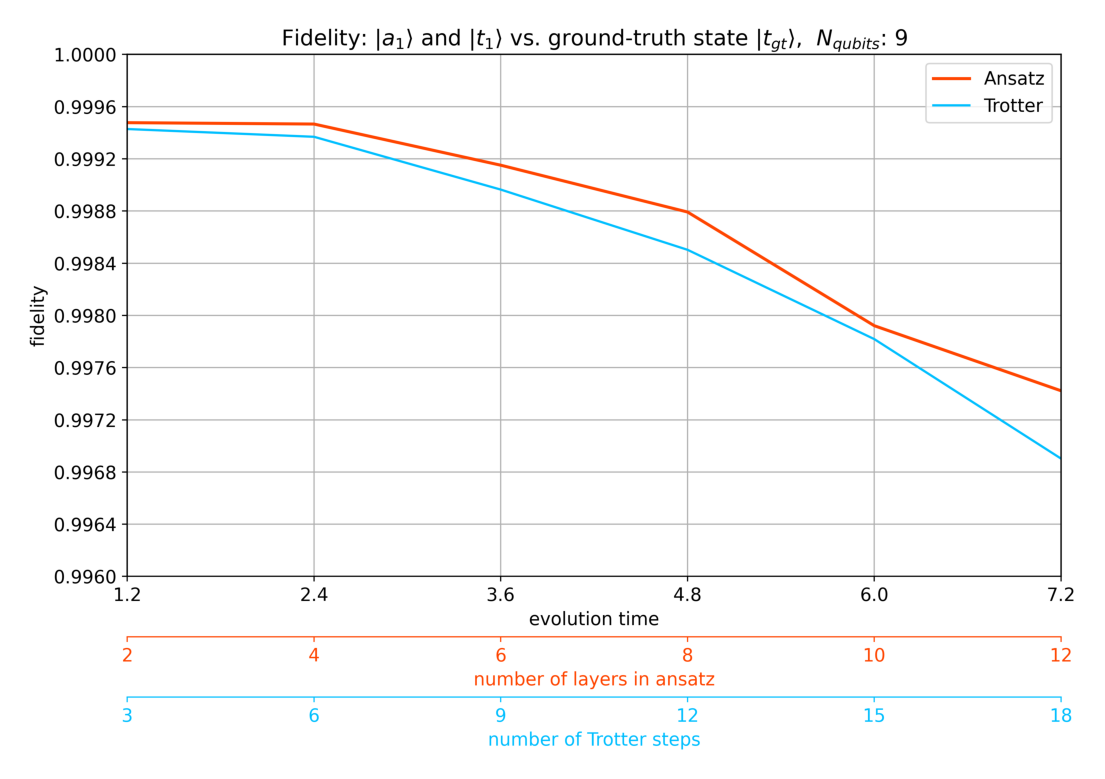

In [4]:
# Tweak the user options.
opts.num_qubits = 9
opts.objective = "sur_max"

# Find the approximating ansatz.
tic = time.time()
out_dir = run_simulation(opts)
print(f"Simulation time: {time.time() - tic:0.1f} secs")
print("Output directory of results:", out_dir)
plot_fidelities(out_dir)

## Experiment 3: full state vectors, perfect initialization and shallow ansatz

Let us try to find even shorter ansatz without sacrifying the accuracy of approximation comparing to the target states. The ansatz is twice less deep than the corresponding Trotter circuit (for the last time horizon), and has larger fidelity. The latter might be not necessary true for $50-100$ qubits, anyway the quality of the solution is comparable to that of the reference Trotter circuit. The shorter ansatz takes more iterations to converge, which is expectable.

2023-05-04 20:20:43 | time_evol_best_init.py | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'delta': 1.0,
 'enable_grad_scaling': True,
 'evol_times': array([1.2, 2.4, 3.6, 4.8, 6. , 7.2]),
 'fidelity_thr': 0.995,
 'ini_state_func': (<function neel_init_state at 0x12c200940>,),
 'manual_num_layers': [2, 4, 6, 7, 8, 9],
 'maxiter': 40,
 'num_layers_inc': 2,
 'num_qubits': 9,
 'objective': 'sur_max',
 'result_dir': '/private/tmp/aqc-research/docs/results/trotter_evol',
 'save_intermediate_results': False,
 'second_order_trotter': True,
 'seed': 1683227900,
 'tag': 'notebook',
 'target_only': False,
 'targets_file': '',
 'time_limit': -1,
 'trotter_steps': array([ 3,  6,  9, 12, 15, 18]),
 'trunc_thr': 1e-06,
 'trunc_thr_target': 1e-16,
 'verbose': True}
--------------------------------------------------------------------------------

2023-05-04 20:20:43 |

2023-05-04 20:20:44 | time_evol_best_init.py | info | 
{'fid_a1_vs_gt': '0.999151',
 'fid_a1_vs_t1': '0.999206',
 'fid_t1_vs_gt': '0.998964'}
--------------------------------------------------------------------------------
2023-05-04 20:20:44 | time_evol_best_init.py | info | 
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Evolution time: 4.800000
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
2023-05-04 20:20:44 | time_evol_best_init.py | info | Fidelity threshold: 0.9985
2023-05-04 20:20:44 | time_evol_best_init.py | info | 
Number of layers: 7
2023-05-04 20:20:44 | time_evol_best_init.py | info | #layers: 7, evol.time: 4.800
2023-05-04 20:20:44 | circuit_structures.py | info | Makes Trotter-like block structure with 7 layers
2023-05-04 20:20:44 | optimizer.py | Warning | enabled gradient amplification in case of barren plateau
2023-05-04 20:20:44 | objective_base.py | info | Objective: SpSurrogateObjectiveMax
2023-05-04 20:20:44 | objective_base.py | info

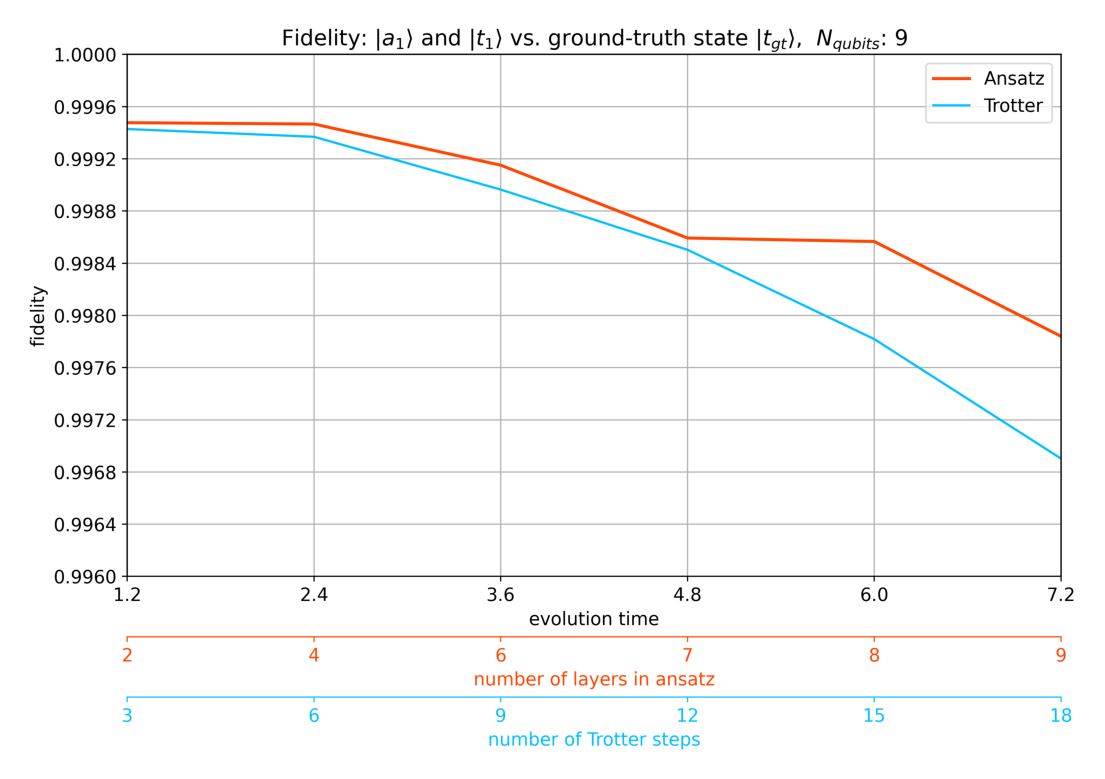

In [5]:
# Tweak the user options.
opts.num_qubits = 9
opts.objective = "sur_max"
opts.manual_num_layers = [2, 4, 6, 7, 8, 9]

# Find the approximating ansatz.
tic = time.time()
out_dir = run_simulation(opts)
print(f"Simulation time: {time.time() - tic:0.1f} secs")
print("Output directory of results:", out_dir)
plot_fidelities(out_dir)

### Looking inside the file of simulation results

The following few cells demonstrate how to extract information from the file of all simulation results. Note, the file can be huge in size (dozens of gigabytes in case of large number of qubits), so its content can easily overwhelm computer memory.
The path to simulation results - ``out_dir`` - returned from last experiment will be used. One can replace it with any valid path as well.

In [ ]:
print("Result's path:", out_dir)
data = trotul.load_results_from_archive(os.path.join(out_dir, "all_results.pkl"))
result_no = 1
print(f"Simulation result of the time horizon at t = {data[result_no]['evol_time1']}:")
trotul.print_results(data, result_no=result_no)

In [ ]:
horizon = data[0]
print("Quantum circuit obtained from optimized ansatz at t =", horizon["evol_time1"])
print("Gates with nearly-zero angular parameters will be discarded.")
solution_qc = trotul.qcircuit_from_result(horizon, tol=1e-8)
solution_qc.draw(output="mpl")

In [ ]:
if data[5]["stats"] is not None:
    print("Convergence profile of the objective function of 6th time horizon.")
    print("Spike always happens in case of L-BFGS optimizer and 'perfect' initial guess,")
    print("but it does not obstruct the quick convergence.")
    yy = np.asarray(data[5]["stats"]["fobj"])
    xx = np.arange(yy.size) + 1
    plt.ylim(0, 1)
    plt.xticks(xx, xx)
    plt.grid()
    plt.title(f"Convergence profile of the objective function")
    plt.ylabel("objective function")
    plt.xlabel("iteration")
    plt.plot(xx, yy, marker='o', color='b')
    plt.show()

In [ ]:
print("User options loaded from the file stored along with other results:\n")
with open(os.path.join(out_dir, "user_options.pkl"), "rb") as fld:
    uopts = pickle.load(fld)
pprint({k: v for k, v in uopts.__dict__.items() if not k.startswith("__")})

# References

1. N.F. Robertson, A. Akhriev, J. Vala, S. Zhuk, "Escaping barren plateaus in approximate quantum compiling," https://arxiv.org/abs/2210.09191
2. N.F. Robertson, A. Akhriev, J. Vala, S. Zhuk, "Approximate Quantum Compiling for Quantum Simulation: A Tensor Network based approach," https://arxiv.org/abs/2301.08609